## 一、RNN从零开始实现

In [1]:
%matplotlib inline
import re
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
batch_size, num_steps = 32, 35
time_machine = d2l.TimeMachine(batch_size, num_steps)

In [3]:
vocab = time_machine.vocab  # 词表示
train_iter = time_machine.get_dataloader(True)  # 训练集

In [4]:
len(vocab)

28

### 独热编码

In [5]:
F.one_hot(torch.tensor([0, 2]), len(vocab))     # 将[0, 2]展开为长度为len(vocab)大小的独热向量

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

### 小批量数据形状是 (批量大小, 时间步数)

In [6]:
X = torch.arange(10).reshape((2, 5)) # (batch_size, n_step)
F.one_hot(X.T, 28).shape # (n_step, batch_size, n_features)

torch.Size([5, 2, 28])

### 初始化循环神经网络模型的模型参数

In [7]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    #隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    #输出参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    #附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### init_rnn_state函数：在初始化时返回隐藏状态

In [8]:
def init_rnn_state(batch_size, num_hiddens, device): #返回初始隐层状态
    return (torch.zeros((batch_size, num_hiddens), device=device), )

### rnn函数：定义**一个时间步内**计算隐藏状态和输出
更新隐藏状态: $$h_t = \phi(W_{hh}h_{t-1}+W_{hx}x_{t-1}+b_{h})$$
输出: $$o_{t}=\phi(W_{ho}h_{t}+b_{o})$$

In [9]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = [] #n_step个大小为(batch_size, n_outputs)的torch张量列表
    # inputs: (n_step, batch_size, n_features)
    for X in inputs: # 按时序遍历
        # print(X)
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) # (batch_size, n_hiddens)
        Y = torch.mm(H, W_hq) + b_q # (batch_size, n_outputs)
        outputs.append(Y) 
    return torch.cat(outputs, dim=0), (H,) #cat后维数(n_step * batch_size, n_outputs)

In [10]:
params = get_params(len(vocab), 512, d2l.try_gpu())
W_xh, W_hh, b_h, W_hq, b_q = params

In [11]:
W_xh.shape, W_hh.shape

(torch.Size([28, 512]), torch.Size([512, 512]))

In [12]:
x = F.one_hot(X.T, 28).type(torch.float32)[0]
x.shape, torch.mm(x, W_xh).shape

(torch.Size([2, 28]), torch.Size([2, 512]))

In [13]:
W_hq.shape

torch.Size([512, 28])

In [14]:
# 批量大小
batch_size = X.shape[0]

In [15]:
state = init_rnn_state(X.shape[0], 512, d2l.try_gpu())

In [16]:
y, new_state = rnn(F.one_hot(X.T, len(vocab)).type(torch.float32), state, params)

In [17]:
y.shape

torch.Size([10, 28])

In [18]:
new_state[0].shape

torch.Size([2, 512])

### 创建一个类来包装这些函数

In [19]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device) #获得模型初始参数
        self.init_state, self.forward_fn = init_state, forward_fn #隐层初始函数, 前馈函数 
        #注意前馈函数可以换成gru, lstm等
        
    def __call__(self, X, state):
        #输入X: (batch_size, n_step)
        #转置＋onehot后 X:(n_step, batch_size, n_features)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

### 检查输出是否具有正确的形状

In [20]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), 
                      get_params, init_rnn_state, rnn)
# X: (2, 5)  对应(batch_size, n_step)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
#Y: (batch_size * n_step, n_outputs) 
#new_state中一个torch张量(最后一个时间步的隐层)
#new_state[0].shape: (batch_size, n_hiddens)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 首先定义预测函数来生成prefix之后的新字符

In [21]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在`prefix`后面生成新字符"""
    #生成初始隐藏状态
    state = net.begin_state(batch_size=1, device=device) 
    outputs = [vocab[prefix[0]]] #第一个word的整型下标
    #将最近预测的词做成tensor, batch_size=1, n_step=1
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热操作, 保存真值
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller', 10, net, vocab, d2l.try_gpu())

'time travellerklfsoxprkl'

### 梯度裁剪
$$\mathbf{g}\leftarrow min(1, \frac{\theta}{\parallel \mathbf{g} \parallel}) \mathbf{g}$$

In [22]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):#如果使用nn.Module来实现
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum(
        (p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 查看train_iter数据集

In [23]:
count = 0
for X, Y in train_iter:
    if count == 0:#第0个batch
        print(X.shape, Y.shape)
        print(X) # (batch_size(=32), n_step(=35))
        print(Y) # (batch_size, n_step)
        print(''.join([vocab.idx_to_token[i] for i in X[0]])) #打印第0个样本对应句子
        print(''.join([vocab.idx_to_token[i] for i in Y[0]])) #打印第0个样本真值
        print(''.join([vocab.idx_to_token[i] for i in X[1]])) #打印第1个样本对应句子
        print(''.join([vocab.idx_to_token[i] for i in Y[1]])) #打印第1个样本真值
        print()
    if count == 1:#第1个batch, 内容和第0个batch上下承接(有时序关系)
        print(''.join([vocab.idx_to_token[i] for i in X[0]]))
        print(''.join([vocab.idx_to_token[i] for i in Y[0]]))
    count += 1
print(count) #打印batch数量=8

torch.Size([32, 35]) torch.Size([32, 35])
tensor([[ 0, 10, 21,  ..., 14,  6,  0],
        [ 0, 11, 22,  ...,  6,  0, 24],
        [ 4,  6,  0,  ...,  7, 16, 22],
        ...,
        [15,  0, 10,  ..., 13, 13, 10],
        [15, 20,  0,  ...,  5,  0, 21],
        [10,  5,  0,  ..., 20, 10,  6]])
tensor([[10, 21,  0,  ...,  6,  0, 21],
        [11, 22, 14,  ...,  0, 24,  6],
        [ 6,  0, 21,  ..., 16, 22, 15],
        ...,
        [ 0, 10, 21,  ..., 13, 10, 15],
        [20,  0, 20,  ...,  0, 21,  9],
        [ 5,  0, 21,  ..., 10,  6, 19]])
 it s all humbug you know the time 
it s all humbug you know the time t
 jump back for a moment of course w
jump back for a moment of course we

ed and animated the fire burned bri
d and animated the fire burned brig
313


### 定义一个函数在一个迭代周期内训练模型

In [24]:
def train_epoch_ch8(net, train_iter, loss, updater, device,
                   use_random_iter):
    """训练模型一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:#为第一个batch 或者 batch之间时序上不连续
            state = net.begin_state(batch_size=X.shape[0], device=device) #初始化state
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_() # 对之前的部分取消梯度反向传播计算
            else:
                # state对于nn.LSTM或者对于我们从零开始实现的模型是个元组(张量构成)
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1) #reshape真值, 将n_step放在第一维之后拉成一维向量
        X, y = X.to(device), y.to(device)
        y_hat,state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):#调用torch优化函数实现
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

### 循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API实现

In [25]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                           legend=['train'], xlim=[10,num_epochs])
    #初始化优化器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    #训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

### 训练循环神经网络模型(按序迭代batch)

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 0

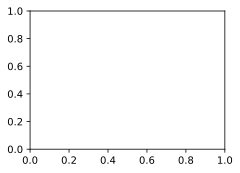

In [26]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

### 训练循环神经网络模型(随机迭代batch)

困惑度 1.2, 74874.5 词元/秒 cpu
time traveller it would be remarkably convenient for the histori
traveller it would be remarkably convenient for the histori


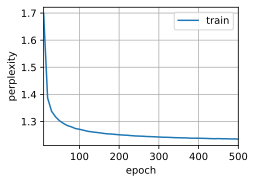

In [27]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

**从零开始实现**上述循环神经网络模型， 虽然有指导意义，但是并不方便。 在下一节中，我们将学习如何改进循环神经网络模型。

## 二、循环神经网络的简洁实现

In [28]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [29]:
batch_size, num_steps = 32, 35
time_machine = d2l.TimeMachine(batch_size, num_steps)
vocab = time_machine.vocab  # 词表示
train_iter = time_machine.get_dataloader(True)  # 训练集

### 定义模型
nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity=tanh, bias=True, batch_first=False, dropout=0, bidirectional=False)

In [30]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

### 使用张量来初始化隐藏状态

In [ ]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape #(D * num_layers(=1), batch_size, num_hiddens) 

torch.Size([1, 32, 256])

### 通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))# (n_step, batch_size, num_inputs)
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

### 定义RNNModel类：完整的循环神经网络模型

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        if not self.rnn.bidirectional: #如果是双向
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size) #线性层 /输出层
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers, 
                                batch_size, self.num_hiddens),
                                device = device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                     torch.zeros((
                         self.num_directions * self.rnn.num_layers,
                         batch_size, self.num_hiddens), device=device))#(h_n, c_n)

### 训练与预测
在训练模型之前，让我们基于一个具有随机权重的模型进行预测。

In [ ]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict_ch8('time traveller', 10, net, vocab, device)

'time traveller<unk>zj<unk><unk>rr<unk>ia'

困惑度 1.3, 151142.9 词元/秒 cpu
time traveller but now you begin to see the object of my investi
traveller but now you begin to see the object of my investi


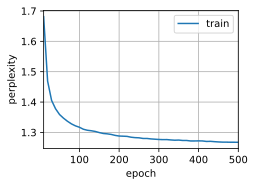

In [ ]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=True)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化， 该模型在较短的时间内达到了较低的困惑度。

### 总结
- **深度学习框架**的高级API提供了循环神经网络层的实现。

- 高级API的循环神经网络层返回一个输出和一个更新后的隐状态，我们**还需要**计算整个模型的**输出层**。

- 相比从零开始实现的循环神经网络，使用**高级API**实现可以**加速训练**。